## Verification in Python ##
**Tyler Wixtrom**<br>
*Texas Tech University*<br>

Unidata Users Workshop<br>
*June 25-28, 2018<br>
Boulder, CO*

The final type of visualization we will explore is that of ensemble verification. In the example, we will perform one of the simplest verification techniques, Root Mean Square Error (RMSE), comparing observed precipitation to both the ensemble mean precipitation and individual members.


In [94]:
from datetime import datetime
from netCDF4 import Dataset, num2date

import numpy as np
import matplotlib.pyplot as plt

### Ensemble Precipitation Plume ###
We will start with the precipitation plume that was created in a previous example.

In [95]:
data = Dataset('../2015020112/wrfprst_d01_2015020112_mem1.nc')
lat = data.variables['lat'][0, :]
lon = data.variables['lon'][0, :]
vtimes = num2date(data.variables['valid_time'][:], data.variables['valid_time'].units)

In [96]:
def lat_lon_2D_index(y, x, lat1, lon1):
    """
    This function calculates the distance from a desired lat/lon point
    to each element of a 2D array of lat/lon values, typically from model output,
    and determines the index value corresponding to the nearest lat/lon grid point.
    x = longitude array
    y = latitude array
    lon1 = longitude point (signle value)
    lat1 = latitude point (single value)
    Returns the index value for nearest lat/lon point on grid
    Equations for variable distiance between longitudes from
    http://andrew.hedges.name/experiments/haversine/
    """
    R = 6373.*1000.  # Earth's Radius in meters
    rad = np.pi/180.
    x1 = np.ones(x.shape)*lon1
    y1 = np.ones(y.shape)*lat1
    dlon = np.abs(x-x1)
    dlat = np.abs(y-y1)
    a = (np.sin(rad*dlat/2.))**2 + np.cos(rad*y1) * np.cos(rad*y) * (np.sin(rad*dlon/2.))**2
    c = 2 * np.arctan2( np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return np.unravel_index(d.argmin(), d.shape)

In [97]:
idx = lat_lon_2D_index(lat, lon, 42.78, -84.59)

In [98]:
pcp = {}
for i in range(1, 21):
    data = Dataset('../2015020112/wrfprst_d01_2015020112_mem'+str(i)+'.nc')
    pcp['mem'+str(i)] = data.variables['tot_pcp'][:-8, idx[0], idx[1]].data

Before plotting, let's calculate the ensemble mean precipitation

In [99]:
mean_pcp = np.mean([pcp[key] for key in pcp.keys()], axis=0)

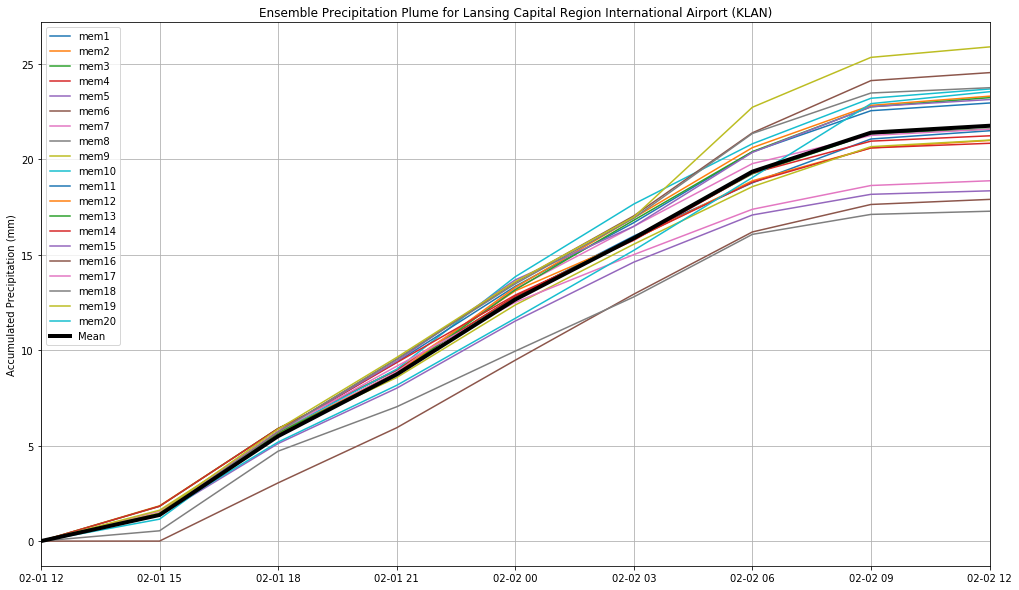

In [100]:
fig = plt.figure(1, figsize=(17., 10.))
for i in range(1, 21):
    plt.plot(vtimes[:-8], pcp['mem'+str(i)], label='mem'+str(i))
plt.plot(vtimes[:-8], mean_pcp, label='Mean', color='k', linewidth=4)
plt.xlim(datetime(2015, 2, 1, 12), datetime(2015, 2, 2, 12))
plt.ylabel('Accumulated Precipitation (mm)')
plt.title('Ensemble Precipitation Plume for Lansing Capital Region International Airport (KLAN)')
plt.grid()
plt.legend()
plt.show()

### Observed Precipitation Data ###
To verify the ensemble precipitation, we will use archived surface ASOS observations from the KLAN station provided by the Iowa State University Iowa Environmental Mesonet (https://mesonet.agron.iastate.edu/archive/) archive. This data is in .csv format, so we will use the Pandas package (https://pandas.pydata.org) to open the data.

In [101]:
obs = np.loadtxt('../2015020112/klan_pcp.csv', skiprows=1, usecols=(2), delimiter=',')
obs_pad = np.concatenate((np.array(0.).reshape(1), obs))
pcp_01h = obs_pad.cumsum()
pcp_03h = pcp_01h[::3]

With the observed precipitation data opened and reformatted, lets plot it along with the ensemble members and mean on the plume to compare each forecast member with the observed precipitation.

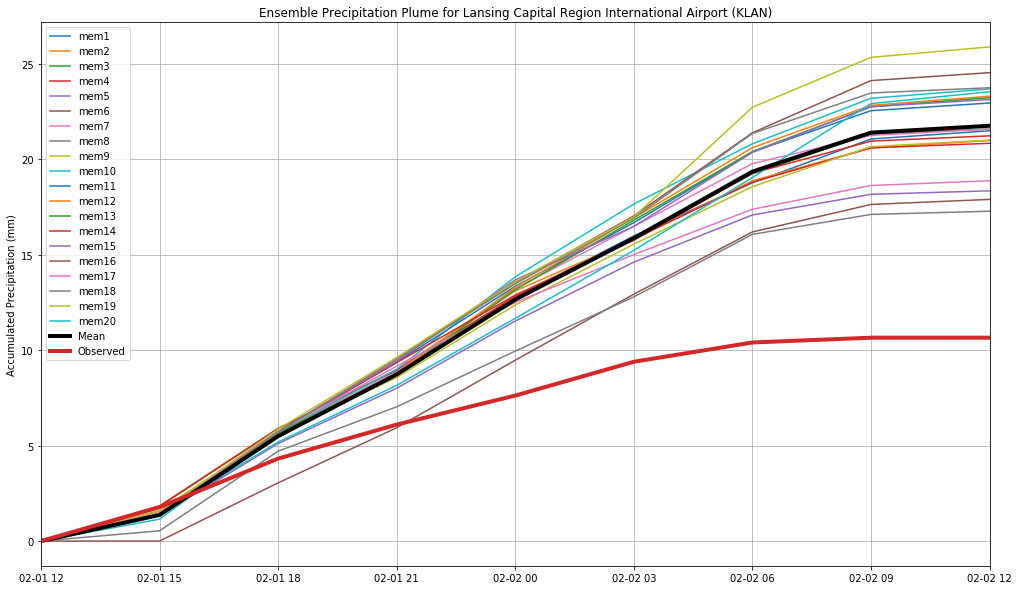

In [103]:
fig = plt.figure(1, figsize=(17., 10.))
for i in range(1, 21):
    plt.plot(vtimes[:-8], pcp['mem'+str(i)], label='mem'+str(i))
plt.plot(vtimes[:-8], mean_pcp, label='Mean', color='k', linewidth=4)
plt.plot(vtimes[:-8], pcp_03h, label='Observed', color='tab:red', linewidth=4)
plt.xlim(datetime(2015, 2, 1, 12), datetime(2015, 2, 2, 12))
plt.ylabel('Accumulated Precipitation (mm)')
plt.title('Ensemble Precipitation Plume for Lansing Capital Region International Airport (KLAN)')
plt.grid()
plt.legend()
plt.show()

Clearly the ensemble is overforecasting precipitation for this location and event. We can quantify the error in each member as well as the mean with the Root Mean Square Error and compare each member.

### Root Mean Square Error (RMSE) ###
The Root Mean Square Error is simply the mean difference between the predicted values and the observed values (<href>http://statweb.stanford.edu/~susan/courses/s60/split/node60.html</href>). This can be applied to both the individual members and the ensemble mean.

In [104]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

Typically, verification statistics are computed for a single lead time over multiple locations and forecasts. For this example, we will simply evaluate the performance of the ensemble in forecasting the above observed precipitation accumulation.

In [105]:
mean_rmse = rmse(mean_pcp, pcp_03h)
ens_rmse = {}
for mem in pcp.keys():
    ens_rmse[mem] = rmse(pcp[mem], pcp_03h)

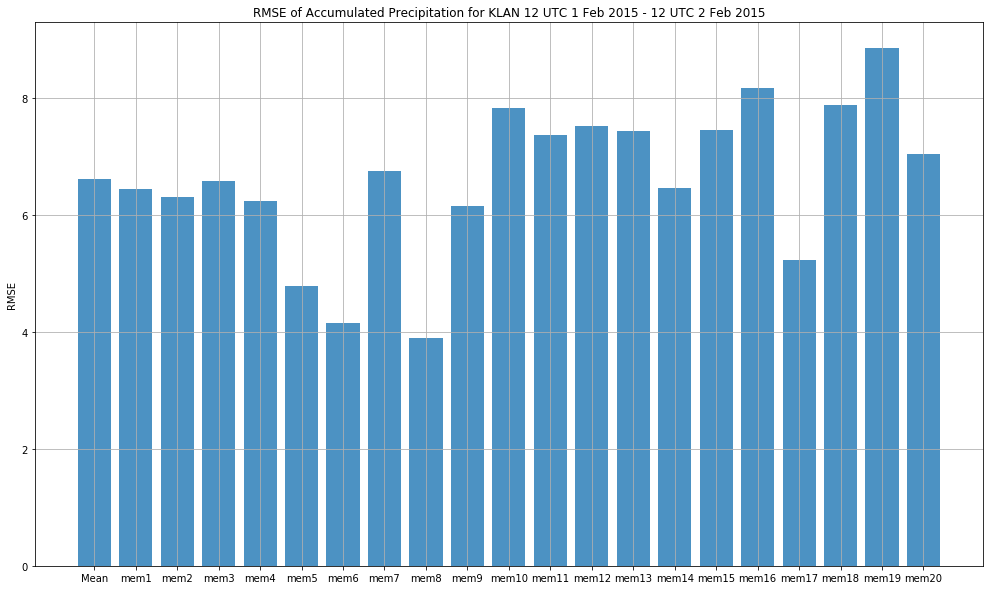

In [113]:
fig = plt.figure(1, figsize=(17., 10.))
members = ['Mean', *[key for key in ens_rmse.keys()]]
y_pos = np.arange(len(members))
 
plt.bar(y_pos, [mean_rmse, *[ens_rmse[key] for key in ens_rmse.keys()]], 
        align='center', alpha=0.8, color='tab:blue')
plt.xticks(y_pos, members)
plt.ylabel('RMSE')
plt.title('RMSE of Accumulated Precipitation for KLAN 12 UTC 1 Feb 2015 - 12 UTC 2 Feb 2015')
plt.grid() 
plt.show()